In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
data = pd.read_csv('/content/drive/Shareddrives/BUDSA 2022-2023/bhacks-workshop/data/Breast_Cancer.csv')
data.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [3]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

## Feature Engineering

(5.5, -0.5)

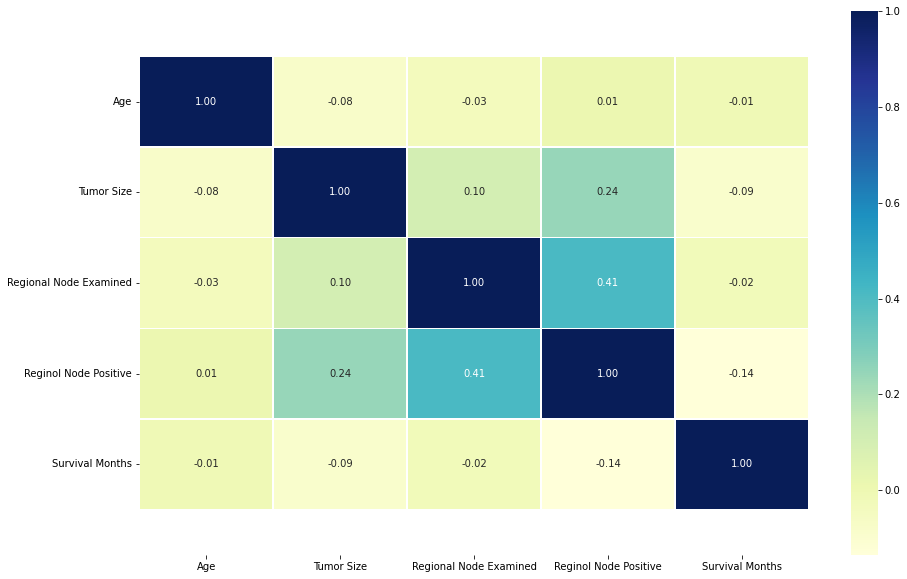

In [4]:
# check corr, important since certain ML models affected by corr
# Let's make our correlation matrix a little prettier
corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [5]:
# check missing data
data.isnull().sum()

Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64

no missing data, no need to fill in missing values

In [6]:
# check which columns are numerical:
for label, content in data.items():
  if pd.api.types.is_numeric_dtype(content): # check whether column is numerical
    print(label)

Age
Tumor Size
Regional Node Examined
Reginol Node Positive
Survival Months


some numerical features are highly skewed, so we will need to transform feature

In [7]:
# check which columns are not numerical
for label, content in data.items():
  if not pd.api.types.is_numeric_dtype(content):
    print(label)

Race
Marital Status
T Stage 
N Stage
6th Stage
differentiate
Grade
A Stage
Estrogen Status
Progesterone Status
Status


need to encode the data before feeding into ML model

In [8]:
categories = ['Race','Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'differentiate', 'Grade']
binaries = ['A Stage','Estrogen Status','Progesterone Status','Status']
data_oneHot = pd.get_dummies(data, columns = categories)
data_oneHot["A Stage"] = data_oneHot["A Stage"].apply(lambda x: 1 if x in ["Regional"] else 0)
data_oneHot["Estrogen Status"] = data_oneHot["Estrogen Status"].apply(lambda x: 1 if x in ["Positive"] else 0)
data_oneHot["Progesterone Status"] = data_oneHot["Progesterone Status"].apply(lambda x: 1 if x in ["Positive"] else 0)
data_oneHot["Status"] = data_oneHot["Status"].apply(lambda x: 1 if x in ["Alive"] else 0)
data_oneHot.head()

,Age,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status,Race_Black,...,6th Stage_IIIB,6th Stage_IIIC,differentiate_Moderately differentiated,differentiate_Poorly differentiated,differentiate_Undifferentiated,differentiate_Well differentiated,Grade_ anaplastic; Grade IV,Grade_1,Grade_2,Grade_3
0,68,1,4,1,1,24,1,60,1,0,...,0,0,0,1,0,0,0,0,0,1
1,50,1,35,1,1,14,5,62,1,0,...,0,0,1,0,0,0,0,0,1,0
2,58,1,63,1,1,14,7,75,1,0,...,0,1,1,0,0,0,0,0,1,0
3,58,1,18,1,1,2,1,84,1,0,...,0,0,0,1,0,0,0,0,0,1
4,47,1,41,1,1,3,1,50,1,0,...,0,0,0,1,0,0,0,0,0,1


## Modeling and Feature Importance

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


X, y = data_oneHot.loc[:, data_oneHot.columns != 'Status'], data_oneHot['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [10]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
  """
  Fits and evaluates given machine learning models.
  models: a dict of different Scikit-Learn machine Learning models
  X_train: training data (no labels)
  X_test: testing data (no labels)
  y_train: training labels
  y_test: test labels
  """
  # Set random seed
  np.random.seed(42)
  # Make a dictionary to keep model scores
  model_scores = {}
  # Loop through models
  for name, model in models.items():
    # Fit the model to the data
    model.fit(X_train, y_train)
    # Evaluate the model and append its score to model_scores
    model_scores[name] = model.score(X_test, y_test)
  return model_scores

In [11]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


{'Logistic Regression': 0.893167701863354,
 'KNN': 0.8906832298136645,
 'Random Forest': 0.9080745341614906}

random forest is slightly better, we will do tuning and feature importance

In [12]:
from sklearn.model_selection import RandomizedSearchCV

# Setup random seed
np.random.seed(42)

# hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}



# Setup random hyperparmeter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)
                           
# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [13]:
# Find the best hyperparameters
rs_rf.best_params_

{'n_estimators': 510,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_depth': None}

In [14]:
rs_rf.score(X_train, y_train)

0.9301025163094129

In [15]:
# Evaluate the randomized search RandomForestClassifier model
rs_rf.score(X_test, y_test)

0.906832298136646

In [16]:
# Make predictions with tuned model
y_preds = rs_rf.predict(X_test)

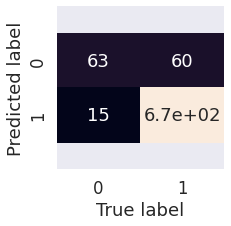

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
  """
  Plots a nice looking confusion matrix using Seaborn's heatmap()
  """
  fig, ax = plt.subplots(figsize=(3,3))
  ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                   annot=True,
                   cbar=False)
  plt.xlabel('True label')
  plt.ylabel('Predicted label')

  bottom, top = ax.get_ylim()
  ax.set_ylim(bottom + 0.5, top - 0.5)

plot_conf_mat(y_test, y_preds)

In [18]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.81      0.51      0.63       123
           1       0.92      0.98      0.95       682

    accuracy                           0.91       805
   macro avg       0.86      0.75      0.79       805
weighted avg       0.90      0.91      0.90       805



## Feature Importance
What features contribute most to the prediction?

Let's find feature importance for our randomforest classifier model

In [19]:
rs_rf.best_params_

{'n_estimators': 510,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_depth': None}

In [20]:
# Fit an instance of LogisticRegression
clf = RandomForestClassifier(n_estimators=910, min_samples_split = 18, min_samples_leaf = 1, max_depth = 10)

clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=18, n_estimators=910)

In [21]:
clf.score(X_test, y_test)

0.9031055900621118

89-91% accuracy with best parameters of randomforestclassifer

In [22]:
# check coef_
clf.feature_importances_

array([0.06321573, 0.00377186, 0.0472488 , 0.02564411, 0.02677181,
       0.0435491 , 0.05520155, 0.51838577, 0.00891843, 0.00627703,
       0.00550612, 0.00579171, 0.00816116, 0.0065225 , 0.00556568,
       0.00517188, 0.00567287, 0.00459199, 0.00452395, 0.00550139,
       0.02094635, 0.00596983, 0.02731034, 0.00744683, 0.0032082 ,
       0.00488372, 0.00245419, 0.02859123, 0.00406141, 0.00904355,
       0.00364825, 0.00457258, 0.00366957, 0.00439833, 0.00443529,
       0.00936692])

In [23]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
  df = (pd.DataFrame({"features": columns,
                      "feature_importances": importances})
  .sort_values("feature_importances", ascending=False)
  .reset_index(drop=True))

  # Plot the dataframe
  fig, ax = plt.subplots(figsize=(15,10))
  ax.barh(df['features'][:n], df["feature_importances"][:20])
  ax.set_ylabel("Features")
  ax.set_xlabel("Feature Importance")
  ax.invert_yaxis()

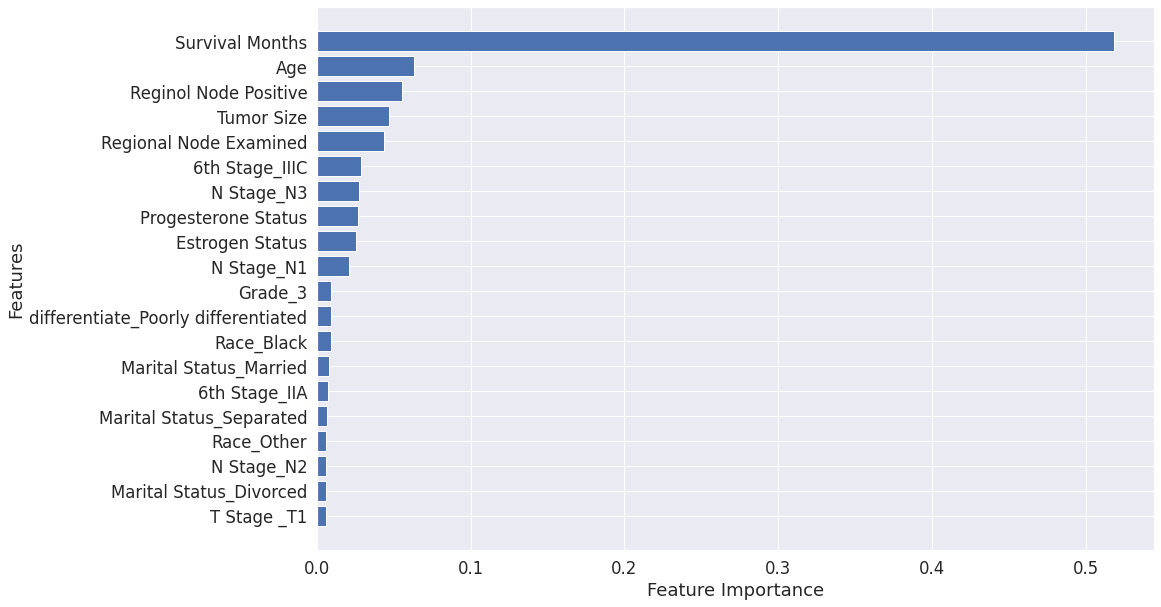

In [24]:
plot_features(X_train.columns, clf.feature_importances_)

# Iterate

Redo the whole process with new features and feature transform

In [25]:
# just in case we need to change the data
data_copy = data.copy()

In [26]:
#  Based on feature importance, we will try drop the least important feature and see accuracy
data_oneHot.drop(['N Stage_N2', '6th Stage_IIIA', 
                'Race_Other', '6th Stage_IIA', 'T Stage _T4', 'Marital Status_Married', 'differentiate_Poorly differentiated', 'Grade_3', 'Marital Status_Separated', 'Race_Black'], axis=1, inplace=True)

In [27]:
X, y = data_oneHot.loc[:, data_oneHot.columns != 'Status'], data_oneHot['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [28]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


{'Logistic Regression': 0.906832298136646,
 'KNN': 0.893167701863354,
 'Random Forest': 0.9031055900621118}

# Conclusion

Seems like dropping these low importance features worsen the performance. We will try **feature transform** and see what will happen

In [29]:
data_copy = data.copy()

In [30]:
# check which columns are numerical:
for label, content in data_copy.items():
  if pd.api.types.is_numeric_dtype(content): # check whether column is numerical
    print(label)

Age
Tumor Size
Regional Node Examined
Reginol Node Positive
Survival Months


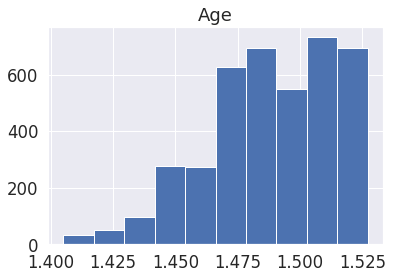

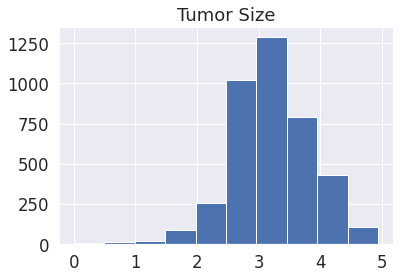

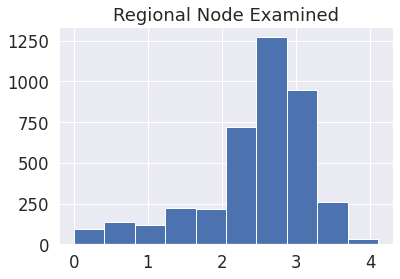

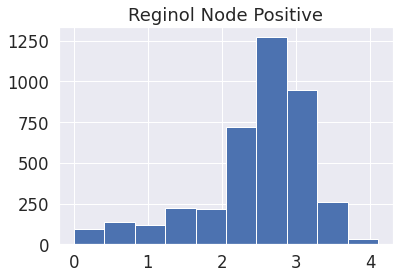

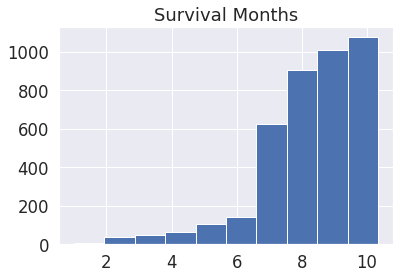

In [31]:
num_columns = ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']
data_copy['Age'] = data['Age'] ** (1/10)
data_copy['Tumor Size'] = np.log(data['Tumor Size'])
data_copy['Regional Node Examined'] = np.log(data['Regional Node Examined'])
data_copy['Reginol Node Positive'] = np.log(data['Regional Node Examined'])
data_copy['Survival Months'] = data['Survival Months'] ** (1/2)
for i in num_columns:
    plt.hist(data_copy[i])
    plt.title(i)
    plt.show()

In [32]:
categories = ['Race','Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'differentiate', 'Grade']
binaries = ['A Stage','Estrogen Status','Progesterone Status','Status']
data_oneHot_copy = pd.get_dummies(data_copy, columns = categories)
data_oneHot_copy["A Stage"] = data_oneHot_copy["A Stage"].apply(lambda x: 1 if x in ["Regional"] else 0)
data_oneHot_copy["Estrogen Status"] = data_oneHot_copy["Estrogen Status"].apply(lambda x: 1 if x in ["Positive"] else 0)
data_oneHot_copy["Progesterone Status"] = data_oneHot_copy["Progesterone Status"].apply(lambda x: 1 if x in ["Positive"] else 0)
data_oneHot_copy["Status"] = data_oneHot_copy["Status"].apply(lambda x: 1 if x in ["Alive"] else 0)
data_oneHot_copy.head()

,Age,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status,Race_Black,...,6th Stage_IIIB,6th Stage_IIIC,differentiate_Moderately differentiated,differentiate_Poorly differentiated,differentiate_Undifferentiated,differentiate_Well differentiated,Grade_ anaplastic; Grade IV,Grade_1,Grade_2,Grade_3
0,1.524933,1,1.386294,1,1,3.178054,3.178054,7.745967,1,0,...,0,0,0,1,0,0,0,0,0,1
1,1.478758,1,3.555348,1,1,2.639057,2.639057,7.874008,1,0,...,0,0,1,0,0,0,0,0,1,0
2,1.500869,1,4.143135,1,1,2.639057,2.639057,8.660254,1,0,...,0,1,1,0,0,0,0,0,1,0
3,1.500869,1,2.890372,1,1,0.693147,0.693147,9.165151,1,0,...,0,0,0,1,0,0,0,0,0,1
4,1.469636,1,3.713572,1,1,1.098612,1.098612,7.071068,1,0,...,0,0,0,1,0,0,0,0,0,1


In [33]:
X, y = data_oneHot_copy.loc[:, data_oneHot_copy.columns != 'Status'], data_oneHot_copy['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [34]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


{'Logistic Regression': 0.8919254658385093,
 'KNN': 0.893167701863354,
 'Random Forest': 0.8993788819875776}

## Moving forward..

I will try various boosting methods since our classes are imbalanced. 